In [1]:
# Import dependencies & libraries
from google.colab import files
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [2]:
# Upload file train.csv & test.csv sebelum menjalankan kode berikutnya
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
# Fungsi u/: cleaning dataset
def clean_data(df):
    # Isi missing value pada kolom Popularity dengan mean
    df['Popularity'] = df['Popularity'].fillna(round(df['Popularity'].mean(), 1))

    # Hapus kolom dengan missing values
    cleaned_df = df.drop(["instrumentalness", "key"], axis=1)

    return cleaned_df

In [4]:
def normalize(df):
  # Inisialisasi object StandardScaler()
    scaler = StandardScaler()

    # Normalisasi langsung pada kolom bertipe float64
    df[df.select_dtypes(include=['float64']).columns] = scaler.fit_transform(df.select_dtypes(include=['float64']))

    return df


In [5]:
def df_to_tensor(df):
    # Konversi semua data numerik ke numpy array dan kemudian ke tensor
    df_tensor = torch.tensor(df.select_dtypes(include=['float64', 'int64']).values, dtype=torch.float32)

    return df_tensor

In [6]:
# Fungsi membagi train set menjadi train & validation set
def split_train_validation(df):
    # Memisahkan train_df menjadi train_data dan val_data (80% train, 20% validation)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])

    # Menampilkan informasi jumlah data
    print("Jumlah data training:", len(train_df))
    print("Jumlah data validation:", len(val_df))

    return train_df, val_df

In [7]:
def train_model(model, optimizer, train_loader, val_loader, epochs):
    history = {
        "loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }
    best_val_loss = 1.0
    best_epoch = 0

    for ei in range(epochs):
        sum_loss = 0.0
        ncorrect_train = 0
        all_preds_train = []
        all_labels_train = []

        # Training
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            yt = model(x)
            loss = criterion(yt.float(), y.float())
            sum_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Accuracy calculation for training set
            preds_train = torch.argmax(yt, dim=1).cpu().numpy()
            labels_train = torch.argmax(y, dim=1).cpu().numpy()
            all_preds_train.extend(preds_train)
            all_labels_train.extend(labels_train)
            ncorrect_train += (preds_train == labels_train).sum()

        avg_loss_train = sum_loss / len(train_loader.dataset)
        avg_train_acc = ncorrect_train / len(train_loader.dataset) * 100.0

        # Validation
        model.eval()
        with torch.no_grad():
            sum_val_loss = 0.0
            ncorrect_val = 0
            all_preds_val = []
            all_labels_val = []
            for x, y in val_loader:
                yt = model(x)
                loss = criterion(yt.float(), y.float())
                sum_val_loss += loss.item()

                preds_val = torch.argmax(yt, dim=1).cpu().numpy()
                labels_val = torch.argmax(y, dim=1).cpu().numpy()
                all_preds_val.extend(preds_val)
                all_labels_val.extend(labels_val)
                ncorrect_val += (preds_val == labels_val).sum()

            avg_val_loss = sum_val_loss / len(val_loader.dataset)
            avg_val_acc = ncorrect_val / len(val_loader.dataset) * 100.0

            # Metrics for validation
            precision = precision_score(all_labels_val, all_preds_val, average="weighted", zero_division=0)
            recall = recall_score(all_labels_val, all_preds_val, average="weighted", zero_division=0)
            f1 = f1_score(all_labels_val, all_preds_val, average="weighted", zero_division=0)

        # Save metrics
        history["loss"].append(avg_loss_train)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(avg_train_acc)
        history["val_acc"].append(avg_val_acc)
        history["precision"].append(precision)
        history["recall"].append(recall)
        history["f1_score"].append(f1)

        # Check if this is the best epoch
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = ei + 1

        print(
            f"Epoch {ei+1} | Loss: {avg_loss_train:.4f} | Val Loss: {avg_val_loss:.4f} | "
            f"Train Acc: {avg_train_acc:.2f}% | Val Acc: {avg_val_acc:.2f}% | "
            f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}"
        )

    print(f"\nBest Epoch: {best_epoch} | Best Val Loss: {best_val_loss}")

    return history, best_epoch, best_val_loss

In [8]:

# Load data
train_df = pd.read_csv('train.csv')
test_df= pd.read_csv('test.csv')

# ----------------!!!-----------------------
# Hitung jumlah missing value per kolom
missing_values_train = train_df.isna().sum()

# Tampilkan jumlah missing value
print(missing_values_train)

# Jika ingin melihat hanya kolom yang memiliki missing value
missing_values_train = missing_values_train[missing_values_train > 0]
print("Kolom pada training set dengan missing values:")
print(missing_values_train)

# ----------------!!!-----------------------
# Hitung jumlah missing value per kolom
missing_values_test = test_df.isna().sum()

# Tampilkan jumlah missing value
print(missing_values_test)

# Jika ingin melihat hanya kolom yang memiliki missing value
missing_values_test = missing_values_test[missing_values_test > 0]
print("Kolom pada test set dengan missing values:")
print(missing_values_test)

# Bersihkan dataset
cleaned_train_df = clean_data(train_df)
cleaned_test_df = clean_data(test_df)

# Simpan dataset
cleaned_train_df.to_csv('train_cleaned.csv', index=False)
cleaned_test_df.to_csv('test_cleaned.csv', index=False)

# Normalisasi dataset
cleaned_trained_df = normalize(cleaned_train_df)
cleaned_test_df = normalize(cleaned_test_df)

# Bagi train set menjadi train & validation set
train_df, val_df = split_train_validation(cleaned_train_df)

# Tranformasi train, validation, & test set menjadi tensor
train_tensor = df_to_tensor(train_df)
val_tensor = df_to_tensor(val_df)
test_tensor = df_to_tensor(cleaned_test_df)

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64
Kolom pada training set dengan missing values:
Popularity           428
key                 2014
instrumentalness    4377
dtype: int64
Artist Name              0
Track Name               0
Popularity             227
danceability             0
energy                   0
key                    808
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      1909
liveness                 0
valence                  0
tempo                    0
duration_in min

In [9]:
print(train_tensor)
print(val_tensor)
print(test_tensor)

tensor([[ 1.8869,  1.3868, -1.0655,  ..., -0.7500,  4.0000,  5.0000],
        [-1.4236, -0.1109,  0.5405,  ..., -0.2458,  4.0000, 10.0000],
        [-0.0297,  0.3763, -0.7978,  ..., -0.5143,  4.0000, 10.0000],
        ...,
        [ 0.6672, -0.0567, -0.2837,  ...,  0.1261,  4.0000,  5.0000],
        [-1.4236,  0.4304, -0.8403,  ..., -1.7926,  4.0000,  3.0000],
        [-0.3782,  2.2168,  0.3536,  ..., -0.6870,  4.0000,  5.0000]])
tensor([[-0.7848,  0.4966, -0.3559,  ..., -1.7925,  4.0000,  3.0000],
        [-0.9590,  0.0455, -0.9465,  ..., -0.3146,  4.0000,  6.0000],
        [ 0.3187, -0.0206,  1.2586,  ..., -0.0762,  4.0000,  8.0000],
        ...,
        [-0.4363,  0.1297, -0.5131,  ...,  2.8993,  4.0000, 10.0000],
        [-0.9590, -1.3859,  0.9654,  ...,  0.1420,  4.0000, 10.0000],
        [-0.3201, -0.1289,  1.2925,  ...,  0.6345,  4.0000,  8.0000]])
tensor([[ 1.6352e+00, -1.4440e+00, -1.1093e+00,  ...,  3.8704e-01,
          1.0486e+00,  4.0000e+00],
        [-6.3987e-01, -2.2505

In [10]:
# (Optional) download file csv yg sudah dibersihkan
# files.download("train_cleaned.csv")
# files.download("test_cleaned.csv")

In [11]:
# Definisi kelas Dataset
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # Fitur
        self.Y = Y  # Label/target

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Pisahkan fitur (X) dan label (Y)
Xtrain = train_tensor[:, :-1]
Ytrain = train_tensor[:, -1].long()

# Konversi Ytrain menjadi one-hot encoding
Ytrain = torch.nn.functional.one_hot(Ytrain, num_classes=len(torch.unique(Ytrain)))

Xval = val_tensor[:, :-1]
Yval = val_tensor[:, -1].long()

# Konversi Yval menjadi one-hot encoding
Yval = torch.nn.functional.one_hot(Yval, num_classes=len(torch.unique(Yval)))

Xtest = test_tensor[:, :-1]
Ytest = test_tensor[:, -1]

# Ytrain = train_df['Class']  # Kolom kelas sebagai target
# Xtrain = train_df.drop(columns=['Class'])  # Drop kolom kelas dari fitur

# Buat objek dataset
train_set = MyDataset(Xtrain, Ytrain)
val_set = MyDataset(Xval, Yval)
test_set = MyDataset(Xtest, Ytest)

In [12]:
# Gunakan DataLoader untuk batching
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [13]:
 # Pembangunan Model
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, output_size)

        # Inisialisasi bobot menggunakan He untuk layer 1-3
        nn.init.kaiming_normal_(self.layer1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer3.weight, nonlinearity='relu')

        # Inisialisasi bobot menggunakan Xavier untuk layer 4
        nn.init.xavier_normal_(self.layer4.weight)

        # Inisialisasi bias dengan nol
        nn.init.zeros_(self.layer1.bias)
        nn.init.zeros_(self.layer2.bias)
        nn.init.zeros_(self.layer3.bias)
        nn.init.zeros_(self.layer4.bias)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return torch.sigmoid(self.layer4(x)) # Output tanpa fungsi aktivasi, cocok untuk regresi

# print(len(torch.unique(Ytrain)))

# Inisialisasi model dan optimizer
model = MyModel(Xtrain.shape[1], Ytrain.shape[1])
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Inisialisasi loss function
criterion = nn.CrossEntropyLoss()

# Inisialisasi dua model: satu dengan L2 regularization dan satu tanpa
model_with_l2 = MyModel(Xtrain.shape[1], Ytrain.shape[1])
model_without_l2 = MyModel(Xtrain.shape[1], Ytrain.shape[1])

# Optimizer dengan dan tanpa L2 regularization
optimizer_with_l2 = optim.SGD(model_with_l2.parameters(), lr=0.001, weight_decay=1e-4)
optimizer_without_l2 = optim.SGD(model_without_l2.parameters(), lr=0.001)

In [14]:
# Training model tanpa L2 regularization
print("\nTraining model without L2 regularization:")
history_without_l2, best_epoch_without_l2, best_val_loss_without_l2 = train_model(
    model_without_l2, optimizer_without_l2, train_loader, val_loader, epochs=50
)

print("\nTraining model with L2 regularization:")
# Training model dengan L2 regularization
history_with_l2, best_epoch_with_l2, best_val_loss_with_l2 = train_model(
    model_with_l2, optimizer_with_l2, train_loader, val_loader, epochs=50
)


Training model without L2 regularization:
Epoch 1 | Loss: 0.0756 | Val Loss: 0.0755 | Train Acc: 2.92% | Val Acc: 3.14% | Precision: 0.0651 | Recall: 0.0314 | F1-Score: 0.0247
Epoch 2 | Loss: 0.0747 | Val Loss: 0.0747 | Train Acc: 3.72% | Val Acc: 4.11% | Precision: 0.0744 | Recall: 0.0411 | F1-Score: 0.0402
Epoch 3 | Loss: 0.0739 | Val Loss: 0.0739 | Train Acc: 5.01% | Val Acc: 5.81% | Precision: 0.0864 | Recall: 0.0581 | F1-Score: 0.0621
Epoch 4 | Loss: 0.0732 | Val Loss: 0.0732 | Train Acc: 6.83% | Val Acc: 8.03% | Precision: 0.0990 | Recall: 0.0803 | F1-Score: 0.0809
Epoch 5 | Loss: 0.0726 | Val Loss: 0.0725 | Train Acc: 9.61% | Val Acc: 11.64% | Precision: 0.1022 | Recall: 0.1164 | F1-Score: 0.0999
Epoch 6 | Loss: 0.0719 | Val Loss: 0.0718 | Train Acc: 15.44% | Val Acc: 20.08% | Precision: 0.1014 | Recall: 0.2008 | F1-Score: 0.1190
Epoch 7 | Loss: 0.0711 | Val Loss: 0.0708 | Train Acc: 25.25% | Val Acc: 27.50% | Precision: 0.2247 | Recall: 0.2750 | F1-Score: 0.1247
Epoch 8 | Loss

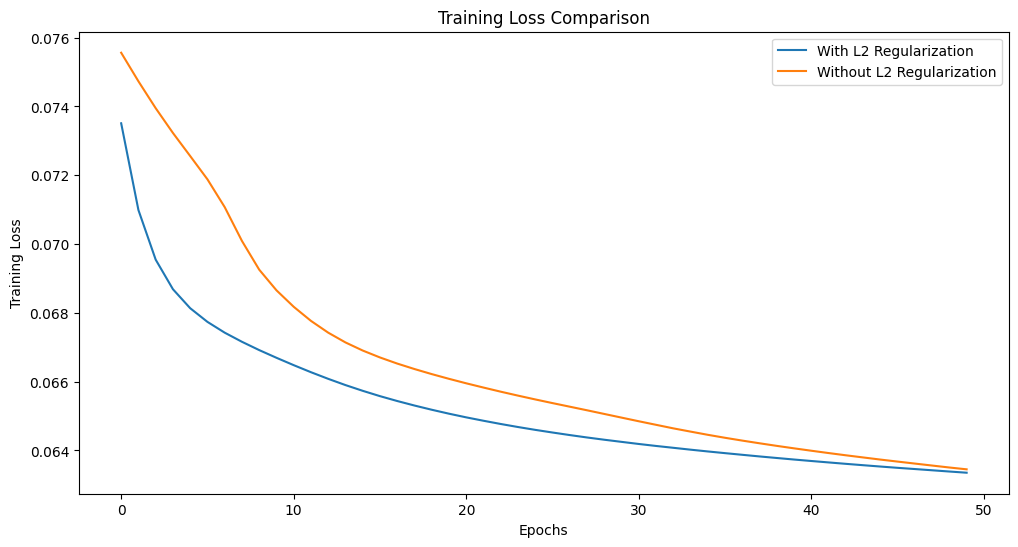

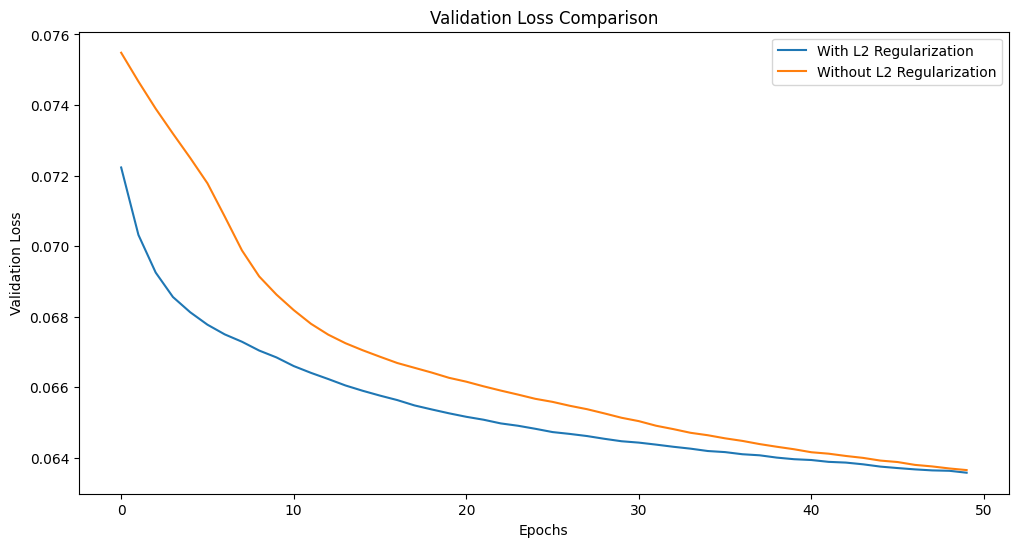

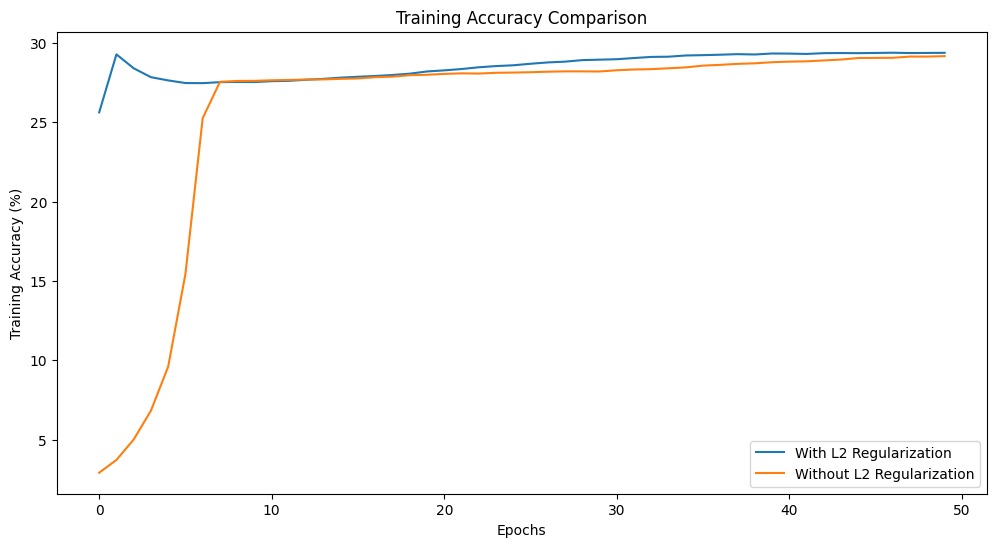

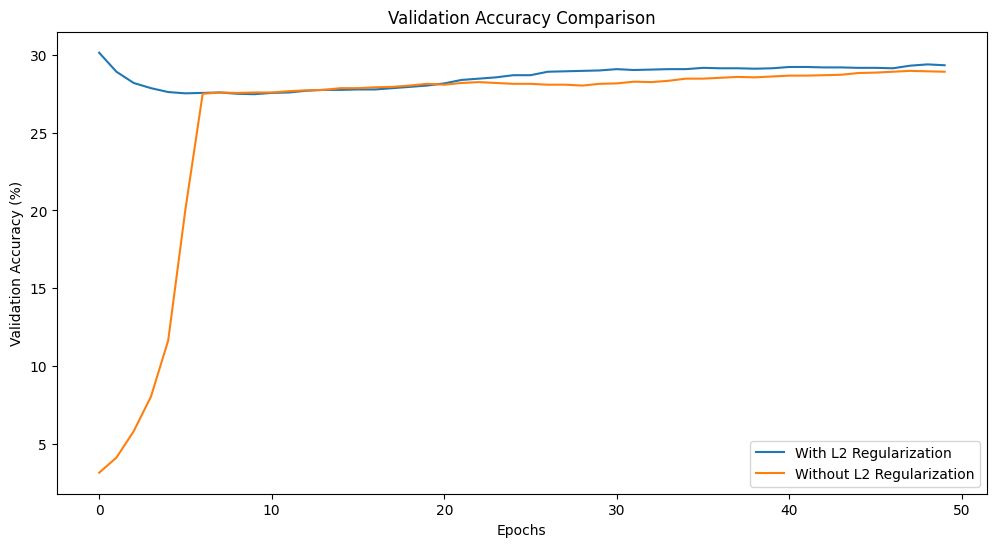

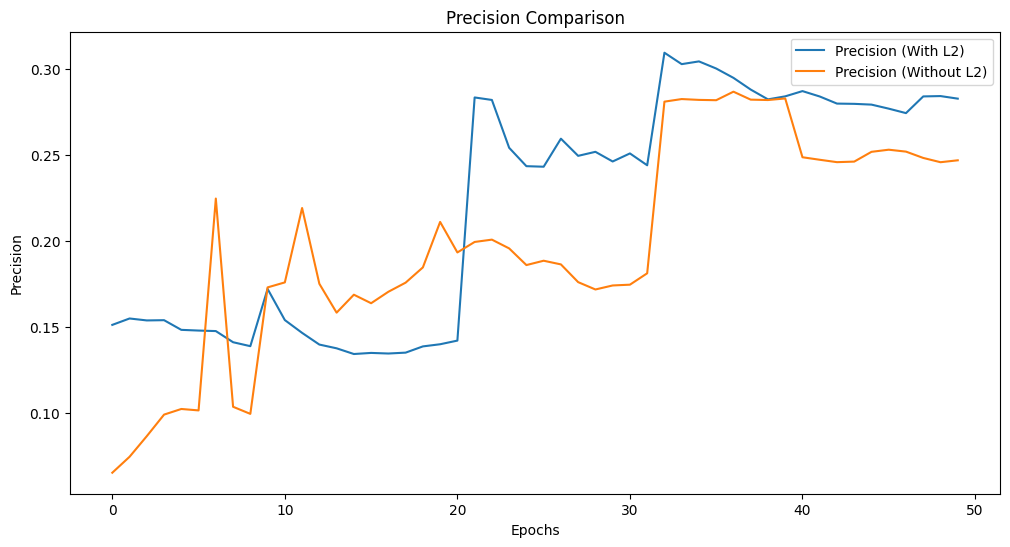

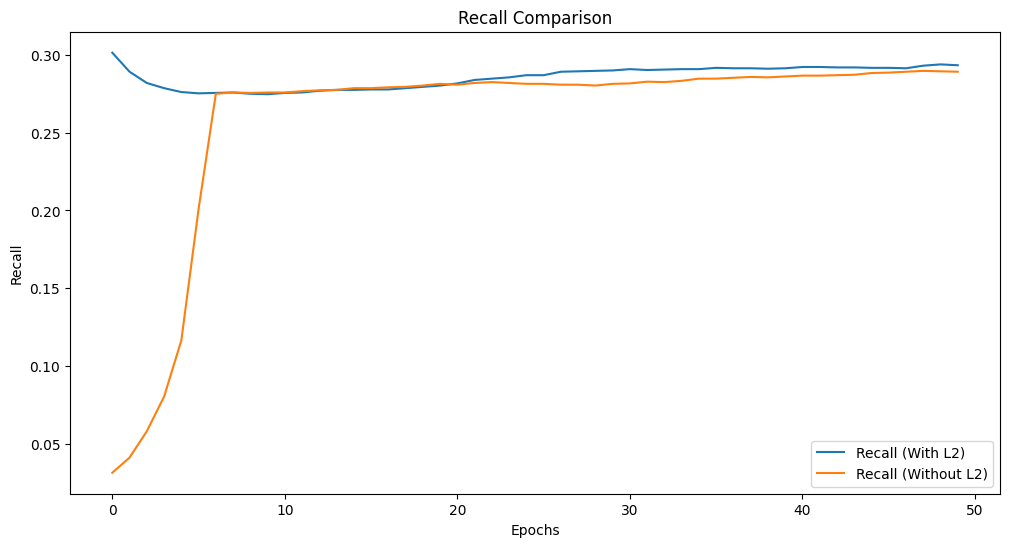

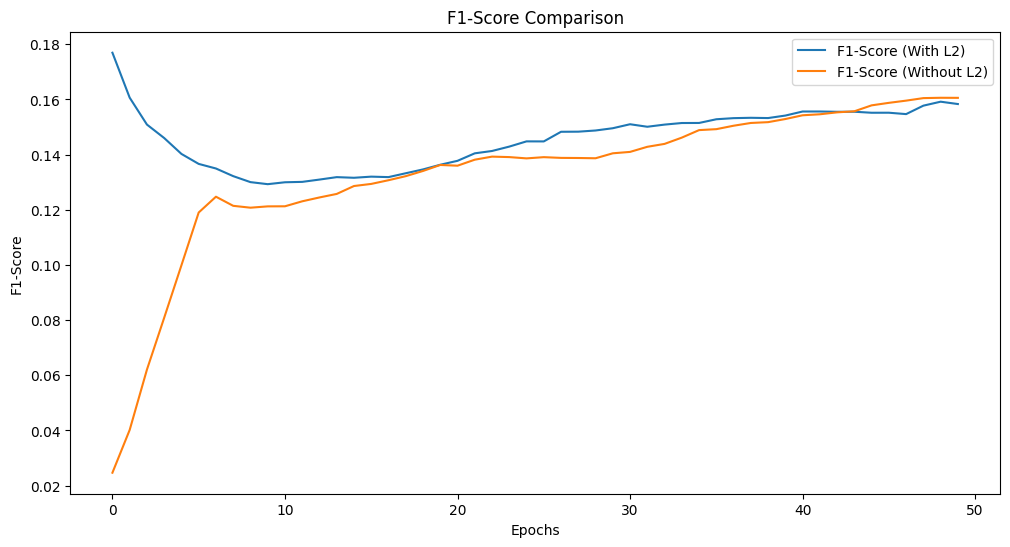

In [16]:
# Visualisasi Perbandingan Metrik

# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.plot(history_with_l2["loss"], label="With L2 Regularization")
plt.plot(history_without_l2["loss"], label="Without L2 Regularization")
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

# Plot Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history_with_l2["val_loss"], label="With L2 Regularization")
plt.plot(history_without_l2["val_loss"], label="Without L2 Regularization")
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_with_l2["train_acc"], label="With L2 Regularization")
plt.plot(history_without_l2["train_acc"], label="Without L2 Regularization")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy (%)")
plt.legend()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_with_l2["val_acc"], label="With L2 Regularization")
plt.plot(history_without_l2["val_acc"], label="Without L2 Regularization")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.show()

# Plot Precision, Recall, dan F1-Score
plt.figure(figsize=(12, 6))
plt.plot(history_with_l2["precision"], label="Precision (With L2)")
plt.plot(history_without_l2["precision"], label="Precision (Without L2)")
plt.title("Precision Comparison")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_with_l2["recall"], label="Recall (With L2)")
plt.plot(history_without_l2["recall"], label="Recall (Without L2)")
plt.title("Recall Comparison")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history_with_l2["f1_score"], label="F1-Score (With L2)")
plt.plot(history_without_l2["f1_score"], label="F1-Score (Without L2)")
plt.title("F1-Score Comparison")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.legend()
plt.show()


In [18]:
print(f"Model tanpa L2: Best Epoch = {best_epoch_without_l2}, Best Val Loss = {best_val_loss_without_l2:.2f}%")
print(f"Model dengan L2: Best Epoch = {best_epoch_with_l2}, Best Val Loss = {best_val_loss_with_l2:.2f}%")

Model tanpa L2: Best Epoch = 50, Best Val Loss = 0.06%
Model dengan L2: Best Epoch = 50, Best Val Loss = 0.06%


Kesimpulan Analisis:
*   Validation Loss untuk model dengan regularisasi L2 > model tanpa regularisasi L2.
*   Model dengan regularisasi L2 menunjukkan performa lebih buruk dibandingkan dengan model tanpa regularisasi L2 berdasarkan rata2 validation loss.

Kemungkinan penyebab:
*   Model belum mengalami overfitting / variansi masih pada tingkat normal ditandai dengan akurasi training & akurasi validation yang tidak berbeda jauh.
*   Regularisasi L2 hanya akan membuat model menjadi underfitting sehingga tidak mampu menghasilkan prediksi yang tepat.

Solusi:
*   Hanya gunakan regularisasi ketika model menunjukkan tanda-tanda overfitting atau terdapat perbedaan yang signifikan antara training error dengan validation error.




Training model with SGD:
Epoch 1 | Loss: 0.0756 | Val Loss: 0.0759 | Train Acc: 8.52% | Val Acc: 8.28% | Precision: 0.1159 | Recall: 0.0828 | F1-Score: 0.0528
Epoch 2 | Loss: 0.0756 | Val Loss: 0.0759 | Train Acc: 8.52% | Val Acc: 8.28% | Precision: 0.1159 | Recall: 0.0828 | F1-Score: 0.0528
Epoch 3 | Loss: 0.0756 | Val Loss: 0.0759 | Train Acc: 8.52% | Val Acc: 8.28% | Precision: 0.1159 | Recall: 0.0828 | F1-Score: 0.0528
Epoch 4 | Loss: 0.0756 | Val Loss: 0.0759 | Train Acc: 8.52% | Val Acc: 8.28% | Precision: 0.1159 | Recall: 0.0828 | F1-Score: 0.0528
Epoch 5 | Loss: 0.0756 | Val Loss: 0.0759 | Train Acc: 8.52% | Val Acc: 8.28% | Precision: 0.1159 | Recall: 0.0828 | F1-Score: 0.0528
Epoch 6 | Loss: 0.0756 | Val Loss: 0.0759 | Train Acc: 8.52% | Val Acc: 8.28% | Precision: 0.1159 | Recall: 0.0828 | F1-Score: 0.0528
Epoch 7 | Loss: 0.0756 | Val Loss: 0.0759 | Train Acc: 8.52% | Val Acc: 8.28% | Precision: 0.1159 | Recall: 0.0828 | F1-Score: 0.0528
Epoch 8 | Loss: 0.0756 | Val Loss: 0

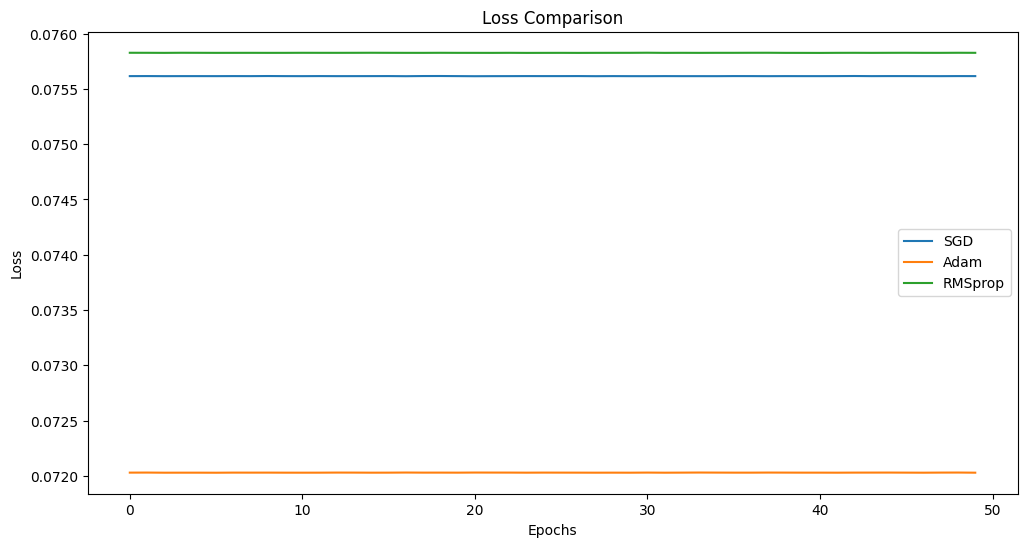

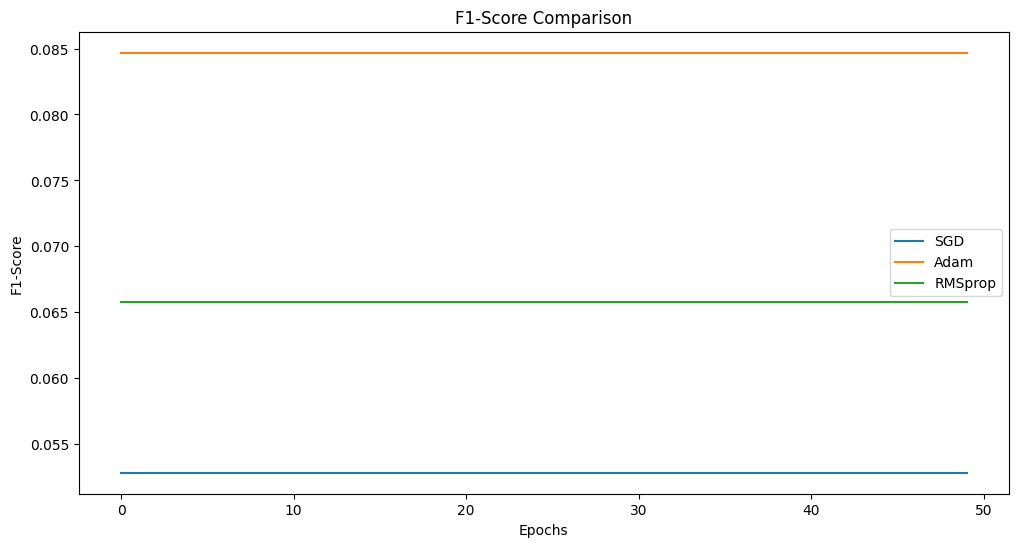

SGD: Best Epoch = 48, Best Val Acc = 0.08%
Adam: Best Epoch = 8, Best Val Acc = 0.07%
RMSprop: Best Epoch = 47, Best Val Acc = 0.08%


In [20]:
# Training model menggunakan tiga optimizer berbeda

# Optimizer SGD (tanpa L2)
optimizer_sgd = optim.SGD(model.parameters(), lr=0.001)

# Optimizer Adam
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

# Optimizer RMSprop
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001)

# Inisialisasi model untuk setiap optimizer
model_sgd = MyModel(Xtrain.shape[1], Ytrain.shape[1])
model_adam = MyModel(Xtrain.shape[1], Ytrain.shape[1])
model_rmsprop = MyModel(Xtrain.shape[1], Ytrain.shape[1])

# Training model dengan SGD
print("\nTraining model with SGD:")
history_sgd, best_epoch_sgd, best_val_loss_sgd = train_model(
    model_sgd, optimizer_sgd, train_loader, val_loader, epochs=50
)

# Training model dengan Adam
print("\nTraining model with Adam:")
history_adam, best_epoch_adam, best_val_loss_adam = train_model(
    model_adam, optimizer_adam, train_loader, val_loader, epochs=50
)

# Training model dengan RMSprop
print("\nTraining model with RMSprop:")
history_rmsprop, best_epoch_rmsprop, best_val_loss_rmsprop = train_model(
    model_rmsprop, optimizer_rmsprop, train_loader, val_loader, epochs=50
)

# Plot perbandingan Loss untuk setiap optimizer
plt.figure(figsize=(12, 6))
plt.plot(history_sgd["loss"], label="SGD")
plt.plot(history_adam["loss"], label="Adam")
plt.plot(history_rmsprop["loss"], label="RMSprop")
plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot perbandingan F1-Score untuk setiap optimizer
plt.figure(figsize=(12, 6))
plt.plot(history_sgd["f1_score"], label="SGD")
plt.plot(history_adam["f1_score"], label="Adam")
plt.plot(history_rmsprop["f1_score"], label="RMSprop")
plt.title("F1-Score Comparison")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.legend()
plt.show()

# Output hasil terbaik untuk setiap optimizer
print(f"SGD: Best Epoch = {best_epoch_sgd}, Best Val Acc = {best_val_loss_sgd:.2f}%")
print(f"Adam: Best Epoch = {best_epoch_adam}, Best Val Acc = {best_val_loss_adam:.2f}%")
print(f"RMSprop: Best Epoch = {best_epoch_rmsprop}, Best Val Acc = {best_val_loss_rmsprop:.2f}%")
